In [1]:
save_root_path = '.'
fname = 'celebA'
batch_size =256
eval_batch_size = 128
workers = 10
epoch = 10

class Args:
        def __init__(self, **entries):
            self.__dict__.update(entries)

args = Args(save_root_path=save_root_path,
                fname=fname,
                batch_size=batch_size,
                eval_batch_size=eval_batch_size,
                workers=workers,
                epoch=epoch)

In [2]:
import os

from matplotlib.pyplot import text
from dataloader.waterbird import Waterbird, WB_DomainTest
import clip
import torch
import clipfolder.clip as clipours
import torch.nn as nn
import argparse
import time
from PIL import Image

import random
import numpy as np

#set up the device as 2nd GPU
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")


In [3]:
model_list = []
for which_layer in [0,12]:#range(0, 13):
    model, preprocess = clipours.load('ViT-B/32', device, jit=False, extract_last_k_th_token=12 - which_layer) # model are ranked from the early layers to last layers interpretation.
    model_list.append(model)








transofmer total layers 12
 mask for layer 0
 mask for layer 1
 mask for layer 2
 mask for layer 3
 mask for layer 4
 mask for layer 5
 mask for layer 6
 mask for layer 7
 mask for layer 8
 mask for layer 9
 mask for layer 10
 mask for layer 11





transofmer total layers 12





transofmer total layers 12





transofmer total layers 12


In [4]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
class CelebADataset(Dataset):
    def __init__(self, root_dir, df, transform=None):
        self.data = df
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data["image_id"].iloc[idx] # assuming image names are in the first column
        label = self.data["Gray_Hair"].iloc[idx] # assuming labels are in the second column
        img = Image.open(self.root_dir + '/' + img_name).convert("RGB") # you can use PIL to open the image
        img_name = self.data["image_id"].iloc[idx]

        if self.transform:
            img = self.transform(img)

        return img, label, img_name

In [5]:

import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('/local/rcs/hc3295/celebA/vit-spurious-robustness/datasets/celebA/celebA_original.csv')


# Select subsets of data
male_gray_df = df[(df['Male'] == 1) & (df['Gray_Hair'] == 1)]
male_notgray_df = df[(df['Male'] == 1) & (df['Gray_Hair'] == 0)]
female_gray_df = df[(df['Male'] == 0) & (df['Gray_Hair'] == 1)]
female_notgray_df = df[(df['Male'] == 0) & (df['Gray_Hair'] == 0)]

# Sample and concatenate for training
train_df = pd.concat([    male_gray_df.sample(frac=0.8),    female_notgray_df.sample(frac=0.8)], axis=0)

# Get remaining samples for testing
test_df = pd.concat([    male_gray_df.drop(male_gray_df.index.intersection(train_df.index)),    male_notgray_df,    female_gray_df,    female_notgray_df.drop(female_notgray_df.index.intersection(train_df.index))], axis=0)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)



In [6]:
root = "/local/rcs/hc3295/celebA/img_align_celeba/img_align_celeba"
train_dataset = CelebADataset(root, train_df, transform=preprocess)
test_dataset_male_gray = CelebADataset(root, test_df[(test_df["Male"] == 1) & (test_df["Gray_Hair"] == 1)], transform=preprocess)
test_dataset_male_notgray = CelebADataset(root, test_df[(test_df["Male"] == 1) & (test_df["Gray_Hair"] == 0)], transform=preprocess)
test_dataset_female_gray = CelebADataset(root, test_df[(test_df["Male"] == 0) & (test_df["Gray_Hair"] == 1)], transform=preprocess)
test_dataset_female_notgray = CelebADataset(root, test_df[(test_df["Male"] == 0) & (test_df["Gray_Hair"] == 0)], transform=preprocess)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = args.batch_size, shuffle=True, num_workers=args.workers)

test_loader_list = [
    torch.utils.data.DataLoader(test_dataset_male_gray, batch_size = args.eval_batch_size, shuffle=False, num_workers=args.workers),
    torch.utils.data.DataLoader(test_dataset_male_notgray, batch_size = args.eval_batch_size, shuffle=False, num_workers=args.workers),
    torch.utils.data.DataLoader(test_dataset_female_gray, batch_size = args.eval_batch_size, shuffle=False, num_workers=args.workers),
    torch.utils.data.DataLoader(test_dataset_female_notgray, batch_size = args.eval_batch_size, shuffle=False, num_workers=args.workers)
]


In [7]:
from model.network import LinearReadOut
# device = "cuda" if torch.cuda.is_available() else "cpu"

# model_ori, preprocess = clip.load("ViT-B/32", device=device)

LR = LinearReadOut().to(device)
# LR = LR.half()
opt = torch.optim.Adam(list(LR.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)


In [9]:
detect_words = ["face", "gender", "male", "female", "man", "men", "woman", "women", "sex", "boy", "girl", "man face", "woman face", "face", "nose", "eyes", "breast", "shoulder", 'mouth', 'ears', 'shoulders', 'shirt', 'jacket', 'tie', 'scarf', 'watch', 'hat', 'eyebrows', 'lashes', 'iris', 'pupils', 'nostrils', 'lips', 'teeth', 'tongue', 'temples', 'cheeks', 'cheekbones', 'chin', 'throat', 'arms', 'elbows', 'wrists', 'hands', 'fingers', 'chest', 'sternum', 'ribs', 'blouse', 'sweater', 'hoodie', 'blazer', 'pendant', 'watch', 'beanie', 'headband']
object_words=["hair", "gray hair", "gray", "not gray hair", "hairstyle", "curl hair", "straight hair", "hair texture", "shiny hair", "haircut"]

# distractor
import numpy as np
dis = np.load('data/all_words_descriptors.npy')
# dis = list(dis)
# dis2 = np.load('data/all_words_rscid.npy')
# dis = list(dis)
# dis2 = list(dis2)
# dis = list(np.random.choice(dis, 2500))
dis = list(np.random.choice(dis, 1000))
# dis = dis + dis2
# dis = generate_random_words(10000)
all_words = detect_words+object_words +dis
text_set = [f'this is {word}' for word in all_words]
# text_set = [f'this can be described as {word}' for word in all_words]
text_tokens = clip.tokenize(text_set, truncate = True).to(device)

ans_with_cat={}
for i, each in enumerate(all_words):
    ans_with_cat[i] = each

text_fea = None

with torch.no_grad():
    if text_fea == None:
        for i, batch in enumerate(test_loader_list[0]):
            image, y, img_name = batch
            image = image.to(device)
            image_fea, text_fea = model_list[-1](image, text_tokens, get_all_last=True)
            text_fea = text_fea / text_fea.norm(dim=-1, keepdim=True)
            break

In [10]:
for epoch in range(1):#args.epoch+1):
    LR.train()
    # model_ori.train()

    train_acc = 0
    train_loss=0
    train_n = 0
    for i, batch in enumerate(train_loader):
        opt.zero_grad()

        image, y, img_name = batch
        image = image.to(device)
        y = y.to(device)
        with torch.no_grad():
            image_features = model_list[-1].encode_image(image, get_all_last=False)
        out = LR(image_features.float())

        # import pdb; pdb.set_trace()
        loss = criterion(out, y)
        
        loss.backward()
        opt.step()

        train_acc += (out.max(1)[1] == y).sum().item()
        train_n += y.size(0)
        train_loss += loss.item()
        # print(train_loss/train_n)
        # print('train acc', train_acc/train_n)

    print('train acc', train_acc/train_n, train_loss/train_n)

train acc 0.938582195966592 0.0013183374045142382


In [10]:
l1 = len(test_dataset_male_gray)
l2 = len(test_dataset_male_notgray)
l3 = len(test_dataset_female_gray)
l4 = len(test_dataset_female_notgray)

p1 = l1 / (l1 + l2 + l3 + l4)
p2 = l2 / (l1 + l2 + l3 + l4)
p3 = l3 / (l1 + l2 + l3 + l4)
p4 = l4 / (l1 + l2 + l3 + l4)


In [11]:
print(p1, p2, p3, p4)

0.24648453194053838 0.2535154680594616 0.2535154680594616 0.24648453194053838


In [ ]:
val_result=[]

for each_val_loader in test_loader_list:
    test_robust_loss = 0
    test_robust_acc = 0
    test_n = 0
    with torch.no_grad():
        for i, bs_pair in enumerate(each_val_loader):
            X, y, name = bs_pair
            # 
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad():
                image_features = model_list[-1].encode_image(X, get_all_last=False)
                out = LR(image_features.float())
            
            # import pdb; pdb.set_trace()

            test_robust_acc += (out.max(1)[1] == y).sum().item()
            test_robust_loss += loss.item() * y.size(0)
            test_n += y.size(0)
            # print(y.size(0))
        # print(each_val_loader, f'num {test_n}')

    val_result.append(test_robust_acc/test_n)

avg = p1 * val_result[0] + p2 * val_result[1] + p3*val_result[2] + p4*val_result[3]
worst = min(val_result)

print(epoch, f'test avg: {avg}, worst: {worst}', val_result)

# torch.save({'LR': LR.state_dict()},
#         os.path.join(args.fname, f'model_{epoch}.pth'))

In [12]:

def get_interpretation_from_layer(x, layer, attn_blocks, ln_post, text_features, logit_scale):
    with torch.no_grad():
        for i in range(layer,len(attn_blocks)):
            x = attn_blocks[i](x)
        
        x = x.permute(1, 0, 2)
        x = torch.cat([ln_post(x[:, idx, :]).unsqueeze(1) for idx in range(x.size(1))], dim=1)
        image_features = x @ model.visual.proj

        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        

        logits_img = (logit_scale * image_features) @ text_features.t()

        pseudo_target = np.argmax(logits_img.cpu().numpy(), axis=2)


        ans_2 = []
        for bs in range(pseudo_target.shape[0]):
            ans_3 = []
            for it in range(0, pseudo_target.shape[1]): # for each token, put 1 here to avoid CLS token replace
                index = pseudo_target[bs, it]
                ans_3.append(ans_with_cat[index])
            ans_2.append(ans_3)

    return ans_2


In [52]:
#remove detectd tokens
# model = model_ori
no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]

logit_scale = model.logit_scale.exp()



val_result=[]
detected_words_each_loader = []
for each_val_loader in test_loader_list:
    detected_words = []
    test_robust_loss = 0
    test_robust_acc = 0
    test_n = 0
    with torch.no_grad():
        for i, batch in enumerate(each_val_loader):
            X, y, img_name = batch
            # import pdb; pdb.set_trace()
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad():
                x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
                x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
                x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
                x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
                x = x + model.visual.positional_embedding.to(x.dtype)
                x = model.visual.ln_pre(x)
                x = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]

                for i in range(len(attn_blocks)):
                    if i >= 11:
                        interpretations = get_interpretation_from_layer(x, i, no_attention_attn_blocks, model.visual.ln_post, text_fea, logit_scale)
                        tokens_to_remove = []
                        
                        for bs in range(X.size(0)):
                            for token in range(50):
                                if interpretations[bs][token].lower() not in object_words:
                                    tokens_to_remove.append((bs, i, token))
                                # for detect_w in detect_words:
                                #     # if detect_w in interpretations[bs][token]:
                                #     if detect_w.lower() == interpretations[bs][token].lower():
                                #         detected_words.append([bs, i, token, interpretations[bs][token]])
                                #         tokens_to_remove.append((bs, i, token))

                        for bs, layer, token in tokens_to_remove:
                            x[token, bs, :] = torch.zeros_like(x[token, bs, :])
                        
                        print(f'layer {i} detected words: {len(tokens_to_remove)/ X.size(0)}')
                            
                    x = attn_blocks[i](x)


                x = x.permute(1, 0, 2)
                x = x = model.visual.ln_post(x[:, 0, :])
                final = x @ model.visual.proj

                out = LR(final.float())

            test_robust_acc += (out.max(1)[1] == y).sum().item()
            # test_robust_loss += loss.item() * y.size(0)
            test_n += y.size(0)

            # break
    detected_words_each_loader.append(detected_words)

    val_result.append(test_robust_acc/test_n)

    
avg = p1 * val_result[0] + p2 * val_result[1] + p3*val_result[2] + p4*val_result[3]
worst = min(val_result)

print(f'corrected avg: {avg}  worst: {worst}', val_result)


layer 11 detected words: 41.0390625
layer 11 detected words: 41.03125
layer 11 detected words: 41.1328125
layer 11 detected words: 41.75
layer 11 detected words: 40.609375
layer 11 detected words: 40.7578125
layer 11 detected words: 41.2109375
layer 11 detected words: 40.9296875
layer 11 detected words: 41.5625
layer 11 detected words: 41.77333333333333
layer 11 detected words: 39.296875
layer 11 detected words: 38.5
layer 11 detected words: 39.2109375
layer 11 detected words: 38.9453125
layer 11 detected words: 38.6875
layer 11 detected words: 38.9921875
layer 11 detected words: 38.8515625
layer 11 detected words: 38.6796875
layer 11 detected words: 38.6875
layer 11 detected words: 38.763636363636365
layer 11 detected words: 41.328125
layer 11 detected words: 40.7734375
layer 11 detected words: 41.40625
layer 11 detected words: 41.09375
layer 11 detected words: 41.75
layer 11 detected words: 41.515625
layer 11 detected words: 41.15625
layer 11 detected words: 41.9921875
layer 11 detec

average

In [24]:
# model = model_ori
no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]
logit_scale = model_list[-1].logit_scale.exp()
donor_tokens = [[[] for i in range(len(attn_blocks))], [[] for i in range(len(attn_blocks))]]

with torch.no_grad():
    for i, batch in enumerate(train_loader):
        if i > 10:
            break
        X, y, img_name = batch
        # import pdb; pdb.set_trace()
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
            x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
            x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
            x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
            x = x + model.visual.positional_embedding.to(x.dtype)
            x = model.visual.ln_pre(x)
            x = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]

            for i in range(len(attn_blocks)):
                if i >= 11:
                    interpretations = get_interpretation_from_layer(x, i, no_attention_attn_blocks, model.visual.ln_post, text_fea, logit_scale)
                    tokens_to_remove = []
                    
                    for bs in range(X.size(0)):
                        for token in range(50):
                            # for detect_w in detect_words:
                            #     if detect_w in interpretations[bs][token]:
                                # if detect_w.lower() == interpretations[bs][token].lower():
                            if interpretations[bs][token].lower() not in object_words:
                                if y[bs] == 0:
                                    donor_tokens[0][i].append([interpretations[bs][token], x[token, bs, :]])
                                else:
                                    donor_tokens[1][i].append([interpretations[bs][token], x[token, bs, :]])
                        
                x = attn_blocks[i](x)

In [25]:
for i in range(len(attn_blocks)):
    print(f"layer{i} gray {len(donor_tokens[0][i])} not gray {len(donor_tokens[1][i])}")

layer0 gray 0 not gray 0
layer1 gray 0 not gray 0
layer2 gray 0 not gray 0
layer3 gray 0 not gray 0
layer4 gray 0 not gray 0
layer5 gray 0 not gray 0
layer6 gray 0 not gray 0
layer7 gray 0 not gray 0
layer8 gray 0 not gray 0
layer9 gray 0 not gray 0
layer10 gray 0 not gray 0
layer11 gray 53003 not gray 58383


In [74]:
model.logit_scale

Parameter containing:
tensor(4.6052, device='cuda:1', requires_grad=True)

In [53]:
# model = model_ori
no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]

logit_scale = model.logit_scale.exp()

detected_words = []

val_result=[]
for each_val_loader in test_loader_list:
    print("divider")
    test_robust_loss = 0
    test_robust_acc = 0
    test_n = 0
    with torch.no_grad():
        for i, batch in enumerate(each_val_loader):
            # if i > 1:
            #     break
            X, y, img_name = batch
            # import pdb; pdb.set_trace()
            X = X.to(device)
            y = y.to(device)

            
            with torch.no_grad():
                x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
                x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
                x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
                x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
                x = x + model.visual.positional_embedding.to(x.dtype)
                x = model.visual.ln_pre(x)
                x_land = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]
                x_water = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]
                
                

                for i in range(len(attn_blocks)):
                    if i >= 11:
                        interpretations = get_interpretation_from_layer(x_water, i, no_attention_attn_blocks, model.visual.ln_post, text_fea, logit_scale)
                        water_tokens_to_remove = []
                        for bs in range(X.size(0)):
                            for token in range(50):
                                if interpretations[bs][token].lower() not in object_words:
                                    water_tokens_to_remove.append((bs, i, token))
                                # for detect_w in detect_words:
                                #     if detect_w in interpretations[bs][token]:
                                #     # if detect_w.lower() == interpretations[bs][token].lower():
                                #         detected_words.append([bs, i, token, interpretations[bs][token]])
                                #         water_tokens_to_remove.append((bs, i, token))
                        interpretations = get_interpretation_from_layer(x_land, i, no_attention_attn_blocks, model.visual.ln_post, text_fea, logit_scale)
                        land_tokens_to_remove = []
                        for bs in range(X.size(0)):
                            for token in range(50):
                                if interpretations[bs][token].lower() not in object_words:
                                    land_tokens_to_remove.append((bs, i, token))
                                # for detect_w in detect_words:
                                #     if detect_w in interpretations[bs][token]:
                                #     # if detect_w.lower() == interpretations[bs][token].lower():
                                #         detected_words.append([bs, i, token, interpretations[bs][token]])
                                #         land_tokens_to_remove.append((bs, i, token))

                        for bs, layer, token in land_tokens_to_remove:
                            if len(donor_tokens[0][layer]) == 0:
                                x_land[token, bs, :] = random.choice(donor_tokens[0][-1])[1]   
                            else:
                                x_land[token, bs, :] = random.choice(donor_tokens[0][layer])[1] 
                        for bs, layer, token in water_tokens_to_remove:
                            if len(donor_tokens[1][layer]) == 0:
                                x_water[token, bs, :] = random.choice(donor_tokens[1][-1])[1]
                            else:
                                x_water[token, bs, :] = random.choice(donor_tokens[1][layer])[1]
                            
                    x_land = attn_blocks[i](x_land)
                    x_water = attn_blocks[i](x_water)



                x_land = x_land.permute(1, 0, 2)
                x_water = x_water.permute(1, 0, 2)

                x_land = model.visual.ln_post(x_land[:, 0, :])
                x_water = model.visual.ln_post(x_water[:, 0, :])

                final_land = x_land @ model.visual.proj
                final_water = x_water @ model.visual.proj

                out_land = LR(final_land.float())
                out_water = LR(final_water.float())

                print((out_land.max(1)[1] != out_water.max(1)[1]).sum())

                out = (out_land + out_water)/2.0

            test_robust_acc += (out.max(1)[1] == y).sum().item()
            # test_robust_loss += loss.item() * y.size(0)
            test_n += y.size(0)

            # break

    val_result.append(test_robust_acc/test_n)

    
avg = p1 * val_result[0] + p2 * val_result[1] + p3*val_result[2] + p4*val_result[3]
worst = min(val_result)

print(f'corrected avg: {avg}  worst: {worst}', val_result)


divider
tensor(66, device='cuda:1')
tensor(58, device='cuda:1')
tensor(63, device='cuda:1')
tensor(63, device='cuda:1')
tensor(76, device='cuda:1')
tensor(59, device='cuda:1')
tensor(72, device='cuda:1')
tensor(71, device='cuda:1')
tensor(60, device='cuda:1')
tensor(31, device='cuda:1')
divider
tensor(68, device='cuda:1')
tensor(73, device='cuda:1')
tensor(65, device='cuda:1')
tensor(68, device='cuda:1')
tensor(56, device='cuda:1')
tensor(76, device='cuda:1')
tensor(62, device='cuda:1')
tensor(71, device='cuda:1')
tensor(71, device='cuda:1')
tensor(61, device='cuda:1')
divider
tensor(75, device='cuda:1')
tensor(77, device='cuda:1')
tensor(82, device='cuda:1')
tensor(73, device='cuda:1')
tensor(73, device='cuda:1')
tensor(76, device='cuda:1')
tensor(87, device='cuda:1')
tensor(80, device='cuda:1')
tensor(77, device='cuda:1')
tensor(60, device='cuda:1')
divider
tensor(64, device='cuda:1')
tensor(57, device='cuda:1')
tensor(56, device='cuda:1')
tensor(45, device='cuda:1')
tensor(51, devic

vocab test

In [40]:

class_name = ["male gray", "male not gray", "female gray", "female not gray"]
model = model_ori
no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]
logit_scale = model.logit_scale.exp()



val_result=[]
detected_words_each_loader = []
interpretations_each_loader = []
for loader_idx, each_val_loader in enumerate(test_loader_list):
    interpretations_one_loader = []
    detected_words = []
    print("divider")
    print(class_name[loader_idx])
    test_robust_loss = 0
    test_robust_acc = 0
    test_n = 0
    with torch.no_grad():
        for i, batch in enumerate(each_val_loader):
            batch_count = 0

            X, y, name= batch
            # import pdb; pdb.set_trace()
            X = X.to(device)
            y = y.to(device)

            
            with torch.no_grad():
                x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
                x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
                x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
                x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
                x = x + model.visual.positional_embedding.to(x.dtype)
                x = model.visual.ln_pre(x)
                x_land = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]
                x_water = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]
                
                

                for i in range(len(attn_blocks)):
                    interpretations = get_interpretation_from_layer(x_water, i, no_attention_attn_blocks, model.visual.ln_post, text_fea, logit_scale)
                    interpretations_one_loader += interpretations

                    tokens_to_remove = []
                    
                    for bs in range(X.size(0)):
                        for token in range(50):
                            for detect_w in detect_words:
                                # if detect_w in interpretations[bs][token]:
                                if detect_w.lower() == interpretations[bs][token].lower():
                                    detected_words.append([bs, i, token, interpretations[bs][token]])
                                    tokens_to_remove.append((bs, i, token))

                    batch_count += len(tokens_to_remove)
                            
                    x_land = attn_blocks[i](x_land)
                    x_water = attn_blocks[i](x_water)
            print(batch_count)

    detected_words_each_loader.append(detected_words)
    interpretations_each_loader.append(interpretations_one_loader)


divider
male gray
15343
15624
15767
15400
15428
15845
15375
15176
15212
9024
divider
male not gray
15499
15375
15489
15585
15409
15399
15783
15861
15540
13099
divider
female gray
16200
16313
16503
16332
16547
16311
16423
16041
15884
13822
divider
female not gray
16300
16197
16332
16222
16703
16325
16395
16256
16640
9360


In [42]:
import pandas as pd

# create a list to store the value_counts dataframes
value_counts_list = []

# loop through the four datasets
for j in range(4):
    # get the class name and value counts data
    value_counts_data = pd.value_counts([i[3] for i in detected_words_each_loader[j]])
    # print(value_counts_data)
    # create a new dataframe and append it to the list
    df = pd.DataFrame(value_counts_data).reset_index()
    df.columns = [f'{class_name[j]}_Value', 'Count']
    # df.insert(0, 'Class', class_name[j])
    value_counts_list.append(df)

# concatenate the dataframes horizontally
result = pd.concat(value_counts_list, axis=1)
result.to_csv('result.csv', index=False)
# print the concatenated dataframe
# print(result)

In [27]:
flatten_interpretations_each_loader = []
for i in interpretations_each_loader:
    flatten_interpretations_each_loader.append([j for k in i for j in k])

In [28]:
k = 10

# Convert the lists to pandas Series
A_series = pd.Series(flatten_interpretations_each_loader[0])
B_series = pd.Series(flatten_interpretations_each_loader[1])
C_series = pd.Series(flatten_interpretations_each_loader[2])

A_norm = A_series.value_counts(normalize=True)
B_norm = B_series.value_counts(normalize=True)
C_norm = C_series.value_counts(normalize=True)

# Compute the shared count of each word in A with B
shared_AB = np.abs(A_norm * B_norm)
# shared_AB = shared_AB[shared_AB != 0]  # drop zeros

# Compute the absolute count difference of each word in A with C
diff_AC = np.abs(A_norm * C_norm)
# diff_AC = diff_AC[diff_AC != 0]  # drop zeros

# Combine the two Series into a single DataFrame
df = df = pd.DataFrame({})#pd.concat([shared_AB, diff_AC], axis=1, sort=False)

# Compute a score for each word by adding their shared and diff counts
df['score'] = (shared_AB - diff_AC)/diff_AC#df.product(axis=1)

#remove rows with NaN
df = df.dropna()

# Sort the DataFrame by score in descending order
df = df.sort_values('score', ascending=False)

df.to_csv('male_words.csv')

In [29]:
k = 10

# Convert the lists to pandas Series
A_series = pd.Series(flatten_interpretations_each_loader[2])
B_series = pd.Series(flatten_interpretations_each_loader[3])
C_series = pd.Series(flatten_interpretations_each_loader[0])

A_norm = A_series.value_counts(normalize=True)
B_norm = B_series.value_counts(normalize=True)
C_norm = C_series.value_counts(normalize=True)

# Compute the shared count of each word in A with B
shared_AB = np.abs(A_norm * B_norm)
# shared_AB = shared_AB[shared_AB != 0]  # drop zeros

# Compute the absolute count difference of each word in A with C
diff_AC = np.abs(A_norm * C_norm)
# diff_AC = diff_AC[diff_AC != 0]  # drop zeros

# Combine the two Series into a single DataFrame
df = df = pd.DataFrame({})#pd.concat([shared_AB, diff_AC], axis=1, sort=False)

# Compute a score for each word by adding their shared and diff counts
df['score'] = (shared_AB - diff_AC)/diff_AC#df.product(axis=1)

#remove rows with NaN
df = df.dropna()

# Sort the DataFrame by score in descending order
df = df.sort_values('score', ascending=False)

df.to_csv('female_words.csv')

check individual pic

In [94]:
no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]

#x_land and x_water should have separate interpretations
interpretations_all_layers = []
tokens_to_remove_all_layers = []
with torch.no_grad():

    X, y, img_name = test_dataset_male_notgray[1]
    print(img_name)
    # import pdb; pdb.set_trace()
    X = X.to(device).unsqueeze(0)
    # y = y.to(device)

    x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
    x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
    x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
    x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
    x = x + model.visual.positional_embedding.to(x.dtype)
    x = model.visual.ln_pre(x)
    x = x.permute(1, 0, 2)
    # x_land = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]
    # x_water = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]
    
    for i in range(len(attn_blocks)):
        # interpretations = get_interpretation_from_layer(x_water, i, no_attention_attn_blocks, model.visual.ln_post, text_fea.half(), logit_scale.half())
        interpretations = get_interpretation_from_layer(x, i, no_attention_attn_blocks, model.visual.ln_post, text_fea.half(), logit_scale.half())
        interpretations_all_layers.append(interpretations)

        tokens_to_remove = []
        
        for bs in range(X.size(0)):
            for token in range(50):
                for detect_w in detect_words:
                    if detect_w in interpretations[bs][token]:
                        detected_words.append([bs, i, token, interpretations[bs][token]])
                        tokens_to_remove.append((bs, i, token))
        # x_land = attn_blocks[i](x_land)
        # x_water = attn_blocks[i](x_water)
        x = attn_blocks[i](x)
        tokens_to_remove_all_layers.append(tokens_to_remove)


171176.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


171176.jpg


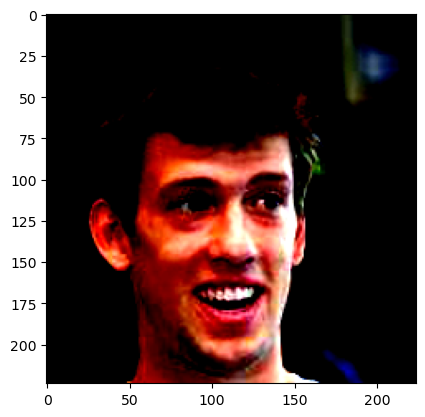

In [63]:
#display test_dataset_male_gray[0][0]
import matplotlib.pyplot as plt
plt.imshow(test_dataset_male_notgray[1][0].permute(1, 2, 0))
print(test_dataset_male_notgray[1][2])

In [95]:
(pd.DataFrame([i[0] for i in interpretations_all_layers]).T)
# (pd.DataFrame([i[0] for i in interpretations_all_layers]).T).to_csv('interpretations_all_layers.csv')

,0,1,2,3,4,5,6,7,8,9,10,11
0,fingerboard,texture,texture,texture,fingerboard,greenish-yellow,fingerboard,fingerboard,fingerboard,neck,neck,droopy
1,spandex,backsplash,ceiling,restaurant,ceiling,ceiling,ceiling,ceiling,book,pattern,pattern,pattern
2,spandex,camouflage,restaurant,vegetation,ceiling,vegetation,purple,suit,chelicerae,musical,long,ticket
3,camouflage,deep-frying,backsplash,mountainous,fretboard,chelicerae,background,compartment,background,background,background,background
4,camouflage,mountainous,pickguard,mountainous,mountainous,wedding,slender,leather,spandex,backsplash,background,background
5,spandex,camouflage,barcode,vegetation,spandex,barcode,barcode,spandex,background,musical,book,musical
6,vegetation,backsplash,ceiling,vegetation,vegetation,nightstand,gray hair,gray hair,loading,black-and-white,black-and-white,seatbelt
7,stackable,suit,spandex,mountainous,barcode,music,decal,staircase,cloth,cafes,cockpit,interior
8,spandex,ceiling,vegetation,restaurant,barcode,barcode,ceiling,background,background,book,tall,musical
9,spandex,mountainous,camouflage,insect,ceiling,chelicerae,chelicerae,musical,gray hair,gray hair,gray hair,gray hair


visualization

In [50]:
def draw_multiple_line_text(text, font, text_color, x_text, text_start_height):
    '''
    From unutbu on [python PIL draw multiline text on image](https://stackoverflow.com/a/7698300/395857)
    '''
    y_text = text_start_height
    lines = textwrap.wrap(text, width=10)
    for line in lines:
        line_width, line_height = font.getsize(line)
        draw.text((x_text, y_text), 
                  line, font=font, fill=text_color)
        y_text += line_height

In [67]:
def get_texts_all_layers_chunk(image_input, text_feas = None):

    if text_feas is None:
        text_feas = [None] * len(texts_list)

    text_logits_list_wordcat = []
    for texts_idx, texts in enumerate(texts_list):
        logits_list_layers = []

        images = image_input
        

        with autocast():
            with torch.no_grad():
                result_tmp = []
                for model_idx, each_model in enumerate(model_list):
                    
                    if text_feas[texts_idx] != None:
                        text_tokens = clip.tokenize(["placeholder"], truncate = True).to(device_list[model_idx])
                        image_fea, _text_fea = each_model(images, text_tokens, get_all_last=True)
                    else: 
                        chunk_size = 1000
                        text_chunks = [texts[i:i+chunk_size] for i in range(0, len(texts), chunk_size)]
                        text_fea_list = []

                        for chunk in text_chunks:
                            text_tokens = clip.tokenize(chunk, truncate=True).to(device_list[model_idx])
                            image_fea, _text_fea = each_model(images, text_tokens, get_all_last=True)
                            text_fea_list.append(_text_fea)
                        
                        text_feas[texts_idx] = torch.cat(text_fea_list, dim=0)
                    
                    selected_interprets = []

                    image_fea, _text_fea = each_model(images.to(device_list[model_idx]), text_tokens, get_all_last=True)
                    if text_feas[texts_idx] is None:
                        text_feas[texts_idx] = _text_fea

                    logits_per_image = image_fea @ text_feas[texts_idx].t()
                    logits_list_layers.append(logits_per_image)

        text_logits_list_wordcat.append(logits_list_layers)

    for i in range(len(texts_list)):
        for j in range(13):
            text_logits_list_wordcat[i][j] = text_logits_list_wordcat[i][j].cpu().numpy()

    categories = ["noun phrases", "adjectives", "nouns only"]
    series = []
    category_mean = np.zeros(len(categories))
    for ind, category in enumerate(categories):
        one_series = []
        for layer in range(13):
            category_mean[ind] += np.mean(text_logits_list_wordcat[ind][layer])
            # print(f"{category} layer {layer} {logits_list_wordcat[ind][12-layer].mean()}")
            one_series.append(text_logits_list_wordcat[ind][12-layer].mean())
        series.append(one_series)

    category_mean /= 13

    nouns_texts_start = 0
    nouns_texts_end = len(nouns_prompts)
    adjs_texts_start = nouns_texts_end
    adjs_texts_end = adjs_texts_start + len(adjs_prompts)
    nouns_only_texts_start = adjs_texts_end
    nouns_only_texts_end = nouns_only_texts_start + len(nouns_only_prompts)


    text_fea_result = []
    result_tmp = []

    max_logits_per_image_list = []

    for model_idx, each_model in enumerate(model_list):

        selected_interpret = []

        logits_per_image_list = [text_logits_list_wordcat[i][model_idx] for i in range(len(text_logits_list_wordcat))]
        logits_per_image = np.concatenate(logits_per_image_list, axis=2)

        logits_per_image[:, :, nouns_texts_start:nouns_texts_end] -= 10000#category_mean[0]
        logits_per_image[:, :, adjs_texts_start:adjs_texts_end] -= category_mean[1]
        logits_per_image[:, :, nouns_only_texts_start:nouns_only_texts_end] -= category_mean[2]

        pseudo_target = np.argmax(logits_per_image, axis=2)
        
        for it in range(pseudo_target.shape[1]): # for each token
            index = pseudo_target[0, it]
            # print(index)
            selected_interpret.append(ans_with_cat[index])
        result_tmp.append((None, selected_interpret))

    text_fea_result.append(result_tmp)

    text_texts_all_layers = []

    for layer in range(13):
        texts_layer = text_fea_result[0][12-layer][1]
        text_texts_all_layers.append(texts_layer)

    return text_texts_all_layers, text_feas


def get_texts_all_layers(image_input, text_feas = None):

    if text_feas is None:
        text_feas = [None] * len(texts_list)

    text_logits_list_wordcat = []
    for texts_idx, texts in enumerate(texts_list):
        logits_list_layers = []

        images = image_input
        text_tokens = clip.tokenize(texts, truncate = True).to(device_list[0])

        with autocast():
            with torch.no_grad():
                result_tmp = []
                for each_model in model_list:

                    if text_feas[texts_idx] != None:
                        text_tokens = clip.tokenize(["placeholder"], truncate = True).to(device_list[0])
                    selected_interprets = []

                    image_fea, _text_fea = each_model(images, text_tokens, get_all_last=True)
                    if text_feas[texts_idx] is None:
                        text_feas[texts_idx] = _text_fea

                    logits_per_image = image_fea @ text_feas[texts_idx].t()
                    logits_list_layers.append(logits_per_image)

        text_logits_list_wordcat.append(logits_list_layers)

    for i in range(len(texts_list)):
        for j in range(13):
            text_logits_list_wordcat[i][j] = text_logits_list_wordcat[i][j].cpu().numpy()


    series = []
    category_mean = np.zeros(len(texts))
    for ind, category in enumerate(texts_list):
        one_series = []
        for layer in range(13):
            category_mean[ind] += np.mean(text_logits_list_wordcat[ind][layer])
            # print(f"{category} layer {layer} {logits_list_wordcat[ind][12-layer].mean()}")
            one_series.append(text_logits_list_wordcat[ind][12-layer].mean())
        series.append(one_series)

    category_mean /= 13

    start_list = []
    end_list = []
    c = 0
    for ind, category in enumerate(texts_list):
        start_list.append(c)
        c += len(category)
        end_list.append(c)

    text_fea_result = []
    result_tmp = []

    max_logits_per_image_list = []

    for model_idx, each_model in enumerate(model_list):

        selected_interpret = []

        logits_per_image_list = [text_logits_list_wordcat[i][model_idx] for i in range(len(text_logits_list_wordcat))]
        logits_per_image = logits_per_image_list[0]#np.concatenate(logits_per_image_list, axis=2)

        # for ind, category in enumerate(texts_list):
        #     logits_per_image[:, :, start_list[ind]:end_list[ind]] -= category_mean[ind]
        #     pass
        print(logits_per_image.shape)
        pseudo_target = np.argmax(logits_per_image, axis=2)
        
        for it in range(pseudo_target.shape[1]): # for each token
            index = pseudo_target[0, it]
            # print(index)
            selected_interpret.append(ans_with_cat[index])
        result_tmp.append((None, selected_interpret))

    text_fea_result.append(result_tmp)

    text_texts_all_layers = []

    for layer in range(13):
        texts_layer = text_fea_result[0][12-layer][1]
        text_texts_all_layers.append(texts_layer)

    return text_texts_all_layers, text_feas

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


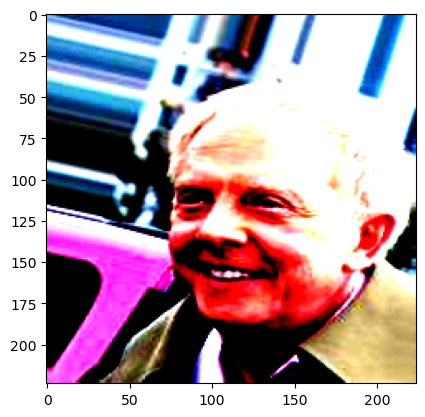

In [47]:
#display img
plt.imshow(img.permute(1, 2, 0).cpu().numpy())

In [24]:
original_images = [test_dataset_male_gray[0][0]]
original_image_input = torch.tensor(np.stack(original_images)).to(device)

In [26]:
# !rm -rf attn/*
from torch.cuda.amp import autocast
texts_list = [text_set]
device_list = ['cuda:2']
texts_all_layers, text_feas = get_texts_all_layers(original_image_input, text_feas = text_fea)
# texts_all_layers, text_feas = get_texts_all_layers(original_image_input, text_feas = text_feas)
print(texts_all_layers[-1][0])

NameError: name 'get_texts_all_layers' is not defined

In [27]:
#old pipeline

# !rm -rf attn/*

logits_list_wordcat = []
for texts in texts_list:
    logits_list_layers = []

    images = original_image_input
    text_tokens = clip.tokenize(texts, truncate = True).to(device)

    with autocast():
        with torch.no_grad():
            result_tmp = []
            for each_model in model_list:
                selected_interprets = []

                image_fea, text_fea = each_model(images, text_tokens, get_all_last=True)
                image_fea = image_fea / image_fea.norm(dim=2, keepdim=True)
                text_fea = text_fea / text_fea.norm(dim=1, keepdim=True)            

                logits_per_image = image_fea @ text_fea.t()
                logits_list_layers.append(logits_per_image)

    logits_list_wordcat.append(logits_list_layers)

for i in range(len(texts_list)):
    for j in range(13):
        logits_list_wordcat[i][j] = logits_list_wordcat[i][j].cpu().numpy()

In [29]:
fea_result = []
result_tmp = []

max_logits_per_image_list = []

for model_idx, each_model in enumerate(model_list):

    selected_interpret = []

    logits_per_image_list = [logits_list_wordcat[i][model_idx] for i in range(len(logits_list_wordcat))]
    logits_per_image = np.concatenate(logits_per_image_list, axis=2)

    # logits_per_image[:, :, nouns_texts_start:nouns_texts_end] -= 10000#category_mean[0]
    # logits_per_image[:, :, adjs_texts_start:adjs_texts_end] -= category_mean[1]
    # logits_per_image[:, :, nouns_only_texts_start:nouns_only_texts_end] -= category_mean[2]

    pseudo_target = np.argmax(logits_per_image, axis=2)
    
    for it in range(pseudo_target.shape[1]): # for each token
        index = pseudo_target[0, it]
        selected_interpret.append(ans_with_cat[index])
    result_tmp.append((None, selected_interpret))

fea_result.append(result_tmp)

texts_all_layers = []

for layer in range(13):
    texts_layer = fea_result[0][layer][1]
    texts_all_layers.append(texts_layer)

In [30]:
(pd.DataFrame([i for i in texts_all_layers]).T)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,mountainous,texture,texture,fingerboard,fingerboard,greenish-yellow,fingerboard,neck,neck,neck,neck,diaphragm,hull
1,gray hair,barcode,aluminum,spaciousness,camouflage,spandex,smoke-colored,ceiling,texture,background,black-and-white,pattern,gray hair
2,wedding,fretboard,touchpad,aluminum,vegetation,smoke-colored,leather,texture,texture,camouflage,background,black-and-white,gray hair
3,barcode,spandex,pickguard,restaurant,vegetation,bus,storage,gray hair,electrical,spillway,backsplash,hair,baseball
4,barcode,ceiling,mountainous,backsplash,background,bus,stand,gray hair,backsplash,fruit,salt-and-pepper,razor-sharp,muscular
5,wedding,gray hair,nightstand,shirt,barcode,deep-frying,camouflage,deep-frying,spandex,camouflage,black-and-white,background,gray hair
6,gray hair,fretboard,backsplash,seatbelt,spandex,touchpad,barcode,background,background,background,background,black-and-white,texture
7,gray hair,fretboard,olive-green,background,ceiling,spandex,background,ceiling,camouflage,pattern,black-and-white,pattern,pattern
8,gray hair,gray hair,pattern,black-and-white,pattern,backsplash,barcode,ceiling,gray hair,greyish-black,ceiling,black-and-white,barcode
9,barcode,building,ammunition,ceiling,tall,barcode,deep-frying,nightstand,nightstand,gray hair,nightstand,hair,muscular


# Training with random + average

In [29]:
no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]

model_list[0].eval()
model_list[-1].eval()
logit_scale = model.logit_scale.exp()
LR = LinearReadOut().to(device)
opt = torch.optim.Adam(list(LR.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(20):#args.epoch+1):
    LR.train()

    train_acc = 0
    train_loss=0
    train_n = 0
    for i, batch in enumerate(train_loader):
        X, y, img_name = batch
        X = X.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
            x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
            x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
            x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
            x = x + model.visual.positional_embedding.to(x.dtype)
            x = model.visual.ln_pre(x)
            x_land = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]
            x_water = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]
            
            for i in range(len(attn_blocks)):
                if i>=11:
                    interpretations = get_interpretation_from_layer(x_water, i, no_attention_attn_blocks, model.visual.ln_post, text_fea, logit_scale)
                    water_tokens_to_remove = []
                    for bs in range(X.size(0)):
                        for token in range(50):
                            if interpretations[bs][token].lower() not in object_words:
                                water_tokens_to_remove.append((bs, i, token))
                            # for detect_w in detect_words:
                            #     # if detect_w in interpretations[bs][token]:
                            #     if detect_w.lower() == interpretations[bs][token].lower():
                            #         # detected_words.append([bs, i, token, interpretations[bs][token]])
                            #         water_tokens_to_remove.append((bs, i, token))
                    interpretations = get_interpretation_from_layer(x_land, i, no_attention_attn_blocks, model.visual.ln_post, text_fea, logit_scale)
                    land_tokens_to_remove = []
                    for bs in range(X.size(0)):
                        for token in range(50):
                            if interpretations[bs][token].lower() not in object_words:
                                land_tokens_to_remove.append((bs, i, token))
                            # for detect_w in detect_words:
                            #     # if detect_w in interpretations[bs][token]:
                            #     if detect_w.lower() == interpretations[bs][token].lower():
                            #         # detected_words.append([bs, i, token, interpretations[bs][token]])
                            #         land_tokens_to_remove.append((bs, i, token))

                    for bs, layer, token in land_tokens_to_remove:
                        if len(donor_tokens[0][layer]) == 0:
                            x_land[token, bs, :] = random.choice(donor_tokens[0][-1])[1]   
                        else:
                            x_land[token, bs, :] = random.choice(donor_tokens[0][layer])[1] 
                    for bs, layer, token in water_tokens_to_remove:
                        if len(donor_tokens[1][layer]) == 0:
                            x_water[token, bs, :] = random.choice(donor_tokens[1][-1])[1]
                        else:
                            x_water[token, bs, :] = random.choice(donor_tokens[1][layer])[1]
                        
                x_land = attn_blocks[i](x_land)
                x_water = attn_blocks[i](x_water)



            x_land = x_land.permute(1, 0, 2)
            x_water = x_water.permute(1, 0, 2)

            x_land = model.visual.ln_post(x_land[:, 0, :])
            x_water = model.visual.ln_post(x_water[:, 0, :])

            final_land = x_land @ model.visual.proj
            final_water = x_water @ model.visual.proj

        out_land = LR(final_land.float())
        out_water = LR(final_water.float())

        # print((out_land.max(1)[1] != out_water.max(1)[1]).sum())

        out = (out_land + out_water)/2.0

        loss = criterion(out, y)
        
        loss.backward()
        opt.step()

        train_acc += (out.max(1)[1] == y).sum().item()
        train_n += y.size(0)
        train_loss += loss.item()
        # print(train_loss/train_n)
        print('train acc', train_acc/train_n)

    print('train acc', train_acc/train_n, train_loss/train_n)

train acc 0.640625
train acc 0.625
train acc 0.6171875
train acc 0.6123046875
train acc 0.61484375
train acc 0.6067708333333334
train acc 0.6043526785714286
train acc 0.59716796875
train acc 0.59765625
train acc 0.598828125
train acc 0.5997869318181818
train acc 0.5989583333333334
train acc 0.6024639423076923
train acc 0.603515625
train acc 0.6002604166666666
train acc 0.60107421875
train acc 0.5990349264705882
train acc 0.6004774305555556
train acc 0.6021792763157895
train acc 0.6
train acc 0.5998883928571429
train acc 0.6019176136363636
train acc 0.6034307065217391
train acc 0.6038411458333334
train acc 0.6046875
train acc 0.6056189903846154
train acc 0.6072048611111112
train acc 0.6056082589285714
train acc 0.6045258620689655
train acc 0.6049479166666667
train acc 0.6057207661290323
train acc 0.6046142578125
train acc 0.60546875
train acc 0.6047794117647058
train acc 0.6043526785714286
train acc 0.6047092013888888
train acc 0.6033572635135135
train acc 0.6034128289473685
train acc 0

In [27]:
# torch.save({'LR': LR.state_dict()}, f'LR_CelebA_random_average_training.pth')

In [33]:
val_result=[]

for each_val_loader in test_loader_list:
    test_robust_loss = 0
    test_robust_acc = 0
    test_n = 0
    with torch.no_grad():
        for i, bs_pair in enumerate(each_val_loader):
            X, y, name = bs_pair
            # 
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad():
                image_features = model_list[-1].encode_image(X, get_all_last= False)
                out = LR(image_features.float())
            
            # import pdb; pdb.set_trace()

            test_robust_acc += (out.max(1)[1] == y).sum().item()
            test_robust_loss += loss.item() * y.size(0)
            test_n += y.size(0)
            # print(y.size(0))
        # print(each_val_loader, f'num {test_n}')

    val_result.append(test_robust_acc/test_n)

avg = p1 * val_result[0] + p2 * val_result[1] + p3*val_result[2] + p4*val_result[3]
worst = min(val_result)

print(epoch, f'test avg: {avg}, worst: {worst}', val_result)

# torch.save({'LR': LR.state_dict()},
#         os.path.join(args.fname, f'model_{epoch}.pth'))

10 test avg: 0.6629168340699076, worst: 0.08003169572107766 [0.9975550122249389, 0.08003169572107766, 0.6148969889064976, 0.9771801140994295]


In [30]:
# model = model_ori
no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]

logit_scale = model.logit_scale.exp()

detected_words = []

val_result=[]
for each_val_loader in test_loader_list:
    print("divider")
    test_robust_loss = 0
    test_robust_acc = 0
    test_n = 0
    with torch.no_grad():
        for i, batch in enumerate(each_val_loader):
            # if i > 1:
            #     break
            X, y, img_name = batch
            # import pdb; pdb.set_trace()
            X = X.to(device)
            y = y.to(device)

            
            with torch.no_grad():
                x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
                x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
                x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
                x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
                x = x + model.visual.positional_embedding.to(x.dtype)
                x = model.visual.ln_pre(x)
                x_land = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]
                x_water = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]
                
                

                for i in range(len(attn_blocks)):
                    if i >= 11:
                        interpretations = get_interpretation_from_layer(x_water, i, no_attention_attn_blocks, model.visual.ln_post, text_fea, logit_scale)
                        water_tokens_to_remove = []
                        for bs in range(X.size(0)):
                            for token in range(50):
                                if interpretations[bs][token].lower() not in object_words:
                                    water_tokens_to_remove.append((bs, i, token))
                                # for detect_w in detect_words:
                                    # if detect_w in interpretations[bs][token]:
                                    # # if detect_w.lower() == interpretations[bs][token].lower():
                                    #     detected_words.append([bs, i, token, interpretations[bs][token]])
                                    #     water_tokens_to_remove.append((bs, i, token))
                        interpretations = get_interpretation_from_layer(x_land, i, no_attention_attn_blocks, model.visual.ln_post, text_fea, logit_scale)
                        land_tokens_to_remove = []
                        for bs in range(X.size(0)):
                            for token in range(50):
                                if interpretations[bs][token].lower() not in object_words:
                                    land_tokens_to_remove.append((bs, i, token))
                                # for detect_w in detect_words:
                                #     if detect_w in interpretations[bs][token]:
                                #     # if detect_w.lower() == interpretations[bs][token].lower():
                                #         detected_words.append([bs, i, token, interpretations[bs][token]])
                                #         land_tokens_to_remove.append((bs, i, token))

                        for bs, layer, token in land_tokens_to_remove:
                            if len(donor_tokens[0][layer]) == 0:
                                x_land[token, bs, :] = random.choice(donor_tokens[0][-1])[1]   
                            else:
                                x_land[token, bs, :] = random.choice(donor_tokens[0][layer])[1] 
                        for bs, layer, token in water_tokens_to_remove:
                            if len(donor_tokens[1][layer]) == 0:
                                x_water[token, bs, :] = random.choice(donor_tokens[1][-1])[1]
                            else:
                                x_water[token, bs, :] = random.choice(donor_tokens[1][layer])[1]
                            
                    x_land = attn_blocks[i](x_land)
                    x_water = attn_blocks[i](x_water)



                x_land = x_land.permute(1, 0, 2)
                x_water = x_water.permute(1, 0, 2)

                x_land = model.visual.ln_post(x_land[:, 0, :])
                x_water = model.visual.ln_post(x_water[:, 0, :])

                final_land = x_land @ model.visual.proj
                final_water = x_water @ model.visual.proj

                out_land = LR(final_land.float())
                out_water = LR(final_water.float())

                print((out_land.max(1)[1] != out_water.max(1)[1]).sum())

                out = (out_land + out_water)/2.0

            test_robust_acc += (out.max(1)[1] == y).sum().item()
            # test_robust_loss += loss.item() * y.size(0)
            test_n += y.size(0)

            # break

    val_result.append(test_robust_acc/test_n)

    
avg = p1 * val_result[0] + p2 * val_result[1] + p3*val_result[2] + p4*val_result[3]
worst = min(val_result)

print(f'corrected avg: {avg}  worst: {worst}', val_result)


divider
tensor(66, device='cuda:1')
tensor(64, device='cuda:1')
tensor(74, device='cuda:1')
tensor(72, device='cuda:1')
tensor(67, device='cuda:1')
tensor(71, device='cuda:1')
tensor(71, device='cuda:1')
tensor(69, device='cuda:1')
tensor(70, device='cuda:1')
tensor(43, device='cuda:1')
divider
tensor(73, device='cuda:1')
tensor(77, device='cuda:1')
tensor(83, device='cuda:1')
tensor(70, device='cuda:1')
tensor(72, device='cuda:1')
tensor(79, device='cuda:1')
tensor(71, device='cuda:1')
tensor(79, device='cuda:1')
tensor(81, device='cuda:1')
tensor(70, device='cuda:1')
divider
tensor(84, device='cuda:1')
tensor(80, device='cuda:1')
tensor(79, device='cuda:1')
tensor(84, device='cuda:1')
tensor(79, device='cuda:1')
tensor(83, device='cuda:1')
tensor(88, device='cuda:1')
tensor(80, device='cuda:1')
tensor(85, device='cuda:1')
tensor(68, device='cuda:1')
divider
tensor(49, device='cuda:1')
tensor(36, device='cuda:1')
tensor(48, device='cuda:1')
tensor(43, device='cuda:1')
tensor(41, devic

# Vocab exploration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


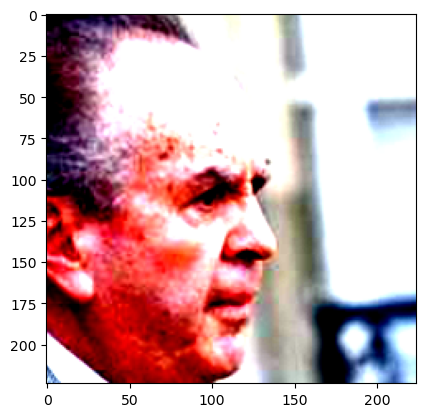

In [52]:
import matplotlib.pyplot as plt
plt.imshow(test_dataset_male_gray[11][0].permute(1, 2, 0))
# print(test_dataset_male_notgray[1][2])

In [55]:
no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]

#x_land and x_water should have separate interpretations
interpretations_all_layers = []
tokens_to_remove_all_layers = []
with torch.no_grad():

    X, y, img_name = test_dataset_male_gray[11]
    print(img_name)
    # import pdb; pdb.set_trace()
    X = X.to(device).unsqueeze(0)
    # y = y.to(device)

    x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
    x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
    x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
    x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
    x = x + model.visual.positional_embedding.to(x.dtype)
    x = model.visual.ln_pre(x)
    x = x.permute(1, 0, 2)
    # x_land = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]
    # x_water = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]
    
    for i in range(len(attn_blocks)):
        # interpretations = get_interpretation_from_layer(x_water, i, no_attention_attn_blocks, model.visual.ln_post, text_fea.half(), logit_scale.half())
        interpretations = get_interpretation_from_layer(x, i, no_attention_attn_blocks, model.visual.ln_post, text_fea.half(), logit_scale.half())
        interpretations_all_layers.append(interpretations)

        tokens_to_remove = []
        
        for bs in range(X.size(0)):
            for token in range(50):
                for detect_w in detect_words:
                    if detect_w in interpretations[bs][token]:
                        detected_words.append([bs, i, token, interpretations[bs][token]])
                        tokens_to_remove.append((bs, i, token))
        # x_land = attn_blocks[i](x_land)
        # x_water = attn_blocks[i](x_water)
        x = attn_blocks[i](x)
        tokens_to_remove_all_layers.append(tokens_to_remove)

    interpretations = get_interpretation_from_layer(x, i+1, no_attention_attn_blocks, model.visual.ln_post, text_fea.half(), logit_scale.half())
    interpretations_all_layers.append(interpretations)
(pd.DataFrame([i[0] for i in interpretations_all_layers]).T)


001533.jpg


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,texture,texture,texture,texture,greyish-black,texture,yellow,neck,neck,neck,neck,man face,eyebrows
1,green,arms,legs,pattern,surface,nightstand,yellow,green,red-brown,greyish-black,hair,hair,address
2,formation,texture,green,padded,leather,gardening,legs,gray hair,tan,gray hair,cylindrical,leather,pyramid-shaped
3,leather,hanging,greyish-black,gardening,tall,black-and-white,water,gray hair,gray hair,gray hair,desk,hair,short
4,pattern,pyramid-shaped,tall,yellow,gardening,gray hair,bus,gardening,yellow,gray hair,greyish-black,cafes,black-and-white
5,gray hair,gardening,gray hair,gray hair,adhesive,gardening,jacket,gray hair,woman face,gray hair,greyish-black,nightstand,black-and-white
6,gray hair,gray hair,pedipalps,gardening,gray hair,yellow,leather,texture,pattern,pattern,black-and-white,greyish-black,cafes
7,gray hair,muscular,gray hair,paper,hands,hairless,desk,gray hair,shirt,black-and-white,pattern,pattern,pattern
8,pyramid-shaped,black-and-white,pattern,yellow,pattern,gray hair,gray hair,leather,bus,greyish-black,gray hair,hairless,tongue
9,gray hair,nightstand,electrical,almond-shaped,gray hair,tall,greyish-black,supply,gray hair,gray hair,tongue,ceramic,short


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,texture,texture,texture,texture,greyish-black,texture,yellow,neck,neck,neck,neck,man face,eyebrows
1,green,arms,legs,pattern,surface,nightstand,yellow,green,red-brown,greyish-black,hair,hair,address
2,formation,texture,green,padded,leather,gardening,legs,gray hair,tan,gray hair,cylindrical,leather,pyramid-shaped
3,leather,hanging,greyish-black,gardening,tall,black-and-white,water,gray hair,gray hair,gray hair,desk,hair,short
4,pattern,pyramid-shaped,tall,yellow,gardening,gray hair,bus,gardening,yellow,gray hair,greyish-black,cafes,black-and-white
5,gray hair,gardening,gray hair,gray hair,adhesive,gardening,jacket,gray hair,woman face,gray hair,greyish-black,nightstand,black-and-white
6,gray hair,gray hair,pedipalps,gardening,gray hair,yellow,leather,texture,pattern,pattern,black-and-white,greyish-black,cafes
7,gray hair,muscular,gray hair,paper,hands,hairless,desk,gray hair,shirt,black-and-white,pattern,pattern,pattern
8,pyramid-shaped,black-and-white,pattern,yellow,pattern,gray hair,gray hair,leather,bus,greyish-black,gray hair,hairless,tongue
9,gray hair,nightstand,electrical,almond-shaped,gray hair,tall,greyish-black,supply,gray hair,gray hair,tongue,ceramic,short


# Training with direct removal

In [23]:
no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]

model_list[0].eval()
model_list[-1].eval()
logit_scale = model.logit_scale.exp()
LR = LinearReadOut().to(device)
opt = torch.optim.Adam(list(LR.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)
for epoch in range(1):
    LR.train()

    train_acc = 0
    train_loss=0
    train_n = 0
    for i, batch in enumerate(train_loader):
        X, y, img_name = batch
        X = X.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
            x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
            x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
            x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
            x = x + model.visual.positional_embedding.to(x.dtype)
            x = model.visual.ln_pre(x)
            x = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]

            for i in range(len(attn_blocks)):
                if i >= 11:
                    interpretations = get_interpretation_from_layer(x, i, no_attention_attn_blocks, model.visual.ln_post, text_fea, logit_scale)
                    tokens_to_remove = []
                    
                    for bs in range(X.size(0)):
                        for token in range(50):
                            if interpretations[bs][token].lower() not in object_words:
                                tokens_to_remove.append((bs, i, token))
                                # detected_words.append([bs, i, token, interpretations[bs][token]])
                            # for detect_w in detect_words:
                                # if detect_w in interpretations[bs][token]:
                                # if detect_w.lower() == interpretations[bs][token].lower():
                                    # detected_words.append([bs, i, token, interpretations[bs][token]])
                                    # tokens_to_remove.append((bs, i, token))

                    for bs, layer, token in tokens_to_remove:
                        if token != 0:
                            x[token, bs, :] = torch.zeros_like(x[token, bs, :])
                    
                    print(f'layer {i} detected words: {len(tokens_to_remove)/ X.size(0)}')
                        
                x = attn_blocks[i](x)


            x = x.permute(1, 0, 2)
            x = x = model.visual.ln_post(x[:, 0, :])
            final = x @ model.visual.proj

        out = LR(final.float())

        loss = criterion(out, y)
        
        loss.backward()
        opt.step()

        train_acc += (out.max(1)[1] == y).sum().item()
        train_n += y.size(0)
        train_loss += loss.item()
        # print(train_loss/train_n)
        print('train acc', train_acc/train_n)

    print('train acc', train_acc/train_n, train_loss/train_n)

layer 11 detected words: 39.26953125
train acc 0.51171875
layer 11 detected words: 38.26171875
train acc 0.548828125
layer 11 detected words: 38.984375
train acc 0.62109375
layer 11 detected words: 39.41796875
train acc 0.68359375
layer 11 detected words: 38.13671875
train acc 0.7203125
layer 11 detected words: 38.46875
train acc 0.75
layer 11 detected words: 39.08984375
train acc 0.7745535714285714
layer 11 detected words: 38.890625
train acc 0.79638671875
layer 11 detected words: 39.12109375
train acc 0.8129340277777778
layer 11 detected words: 39.078125
train acc 0.823828125
layer 11 detected words: 39.1640625
train acc 0.8370028409090909
layer 11 detected words: 39.26171875
train acc 0.8483072916666666
layer 11 detected words: 38.9296875
train acc 0.8578725961538461
layer 11 detected words: 38.89453125
train acc 0.8666294642857143
layer 11 detected words: 39.359375
train acc 0.8731770833333333
layer 11 detected words: 38.890625
train acc 0.87939453125
layer 11 detected words: 39.38

In [24]:
#remove detectd tokens
# model = model_ori
no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]

logit_scale = model.logit_scale.exp()



val_result=[]
detected_words_each_loader = []
for each_val_loader in test_loader_list:
    detected_words = []
    test_robust_loss = 0
    test_robust_acc = 0
    test_n = 0
    with torch.no_grad():
        for i, batch in enumerate(each_val_loader):
            X, y, img_name = batch
            # import pdb; pdb.set_trace()
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad():
                x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
                x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
                x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
                x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
                x = x + model.visual.positional_embedding.to(x.dtype)
                x = model.visual.ln_pre(x)
                x = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]

                for i in range(len(attn_blocks)):
                    if i >= 11:
                        interpretations = get_interpretation_from_layer(x, i, no_attention_attn_blocks, model.visual.ln_post, text_fea, logit_scale)
                        tokens_to_remove = []
                        
                        for bs in range(X.size(0)):
                            for token in range(50):
                                if interpretations[bs][token].lower() not in object_words:
                                    tokens_to_remove.append((bs, i, token))
                                    detected_words.append([bs, i, token, interpretations[bs][token]])
                                # for detect_w in detect_words:
                                #     if detect_w.lower() == interpretations[bs][token].lower():
                                #         detected_words.append([bs, i, token, interpretations[bs][token]])
                                #         tokens_to_remove.append((bs, i, token))

                        for bs, layer, token in tokens_to_remove:
                            if token != 0:
                                x[token, bs, :] = torch.zeros_like(x[token, bs, :])
                        
                        print(f'layer {i} detected words: {len(tokens_to_remove)/ X.size(0)}')
                            
                    x = attn_blocks[i](x)


                x = x.permute(1, 0, 2)
                x = x = model.visual.ln_post(x[:, 0, :])
                final = x @ model.visual.proj

                out = LR(final.float())

            test_robust_acc += (out.max(1)[1] == y).sum().item()
            # test_robust_loss += loss.item() * y.size(0)
            test_n += y.size(0)

            # break
    detected_words_each_loader.append(detected_words)

    val_result.append(test_robust_acc/test_n)

    
avg = p1 * val_result[0] + p2 * val_result[1] + p3*val_result[2] + p4*val_result[3]
worst = min(val_result)

print(f'corrected avg: {avg}  worst: {worst}', val_result)


layer 11 detected words: 41.671875
layer 11 detected words: 41.21875
layer 11 detected words: 40.8359375
layer 11 detected words: 41.2421875
layer 11 detected words: 41.0078125
layer 11 detected words: 40.8671875
layer 11 detected words: 41.2734375
layer 11 detected words: 40.546875
layer 11 detected words: 40.6171875
layer 11 detected words: 41.053333333333335
layer 11 detected words: 39.40625
layer 11 detected words: 38.46875
layer 11 detected words: 39.3046875
layer 11 detected words: 38.921875
layer 11 detected words: 38.84375
layer 11 detected words: 39.109375
layer 11 detected words: 39.203125
layer 11 detected words: 39.0703125
layer 11 detected words: 38.8671875
layer 11 detected words: 38.89090909090909
layer 11 detected words: 41.1328125
layer 11 detected words: 40.390625
layer 11 detected words: 41.34375
layer 11 detected words: 40.890625
layer 11 detected words: 41.546875
layer 11 detected words: 41.390625
layer 11 detected words: 41.1875
layer 11 detected words: 41.84375
l

## Add noise

In [13]:
no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]

logit_scale = model.logit_scale.exp()

In [14]:
center_l2s_batches = []
with_attention_center_batches = []
no_attention_center_batches = []

with torch.no_grad():
    for i, batch in enumerate(train_loader):
        center_l2s = []
        with_attention_center_layers = []
        no_attention_center_layers = []
        X, y, img_name = batch
        X = X.to(device)

        with torch.no_grad():
            x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
            x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
            x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
            x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
            x = x + model.visual.positional_embedding.to(x.dtype)
            x = model.visual.ln_pre(x)
            x = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]

            for i in range(len(attn_blocks)):
                x = attn_blocks[i](x)
                x_no_attention = no_attention_attn_blocks[i](x)
                with_attention_center = x.mean(axis=1)
                no_attention_center = x_no_attention.mean(axis=1)
                with_attention_center_layers.append(with_attention_center)
                no_attention_center_layers.append(no_attention_center)
        with_attention_center_batches.append(with_attention_center_layers)
        no_attention_center_batches.append(no_attention_center_layers)

In [15]:
center_l2s = []
for layer in range(12):
    with_attention_center_this_layer = [with_attention_center_batches[i][layer].unsqueeze(1) for i in range(len(with_attention_center_batches))]
    with_attention_center_this_layer = torch.cat(with_attention_center_this_layer, dim=1)
    with_attention_center = with_attention_center_this_layer.mean(dim=1)
    no_attention_center_this_layer = [no_attention_center_batches[i][layer].unsqueeze(1) for i in range(len(no_attention_center_batches))]
    no_attention_center_this_layer = torch.cat(no_attention_center_this_layer, dim=1)    
    no_attention_center = no_attention_center_this_layer.mean(dim=1)

    center_l2 = torch.sqrt((with_attention_center - no_attention_center)**2).unsqueeze(1)    
    center_l2s.append(center_l2)
    

In [14]:
center_l2s_arr = torch.cat(center_l2s, dim = 1).cpu().numpy()

In [14]:
center_l2s_arr.shape

(50, 12, 768)

In [23]:
print("CelebA")
print(f"CLS drift {center_l2s_arr.mean(axis = 1).mean(axis = 1)[0]}")
print(f"other tokens mean drift {center_l2s_arr.mean(axis = 1).mean(axis = 1)[1:].mean()}")

CelebA
CLS drift 0.0826416015625
other tokens mean drift 0.1031494140625


In [18]:
center_l2s_arr

NameError: name 'center_l2s_arr' is not defined

In [17]:
center_l2s_arr.mean(axis = 0).mean(axis = 1)

array([0.2568 , 0.0655 , 0.0677 , 0.06177, 0.05872, 0.05695, 0.05292,
       0.06097, 0.06073, 0.0985 , 0.1622 , 0.2303 ], dtype=float16)

In [85]:
def get_interpretation_from_layer_smooth_all(x, layer, attn_blocks, ln_post, text_features, logit_scale, ans_with_cat):
    with torch.no_grad():
        x = attn_blocks[layer](x)

        for i in range(layer+1,len(attn_blocks)):
            random_xs = []
            for random_idx in range(500):
                epsilon = torch.randn_like(x) * center_l2s[i-1]
                x_random = x + epsilon / 20
                x_random = attn_blocks[i](x_random)
                random_xs.append(x_random)
            x = torch.stack(random_xs, dim=0).mean(dim=0)
            # print(x.shape)
        
        random_xs = []
        for random_idx in range(500):
            epsilon = torch.randn_like(x) * center_l2s[-1]
            x_random = x + epsilon
            x_random = x_random.permute(1, 0, 2)
            x_random = torch.cat([ln_post(x_random[:, idx, :]).unsqueeze(1) for idx in range(x_random.size(1))], dim=1)
            image_features = x_random @ model.visual.proj
            random_xs.append(image_features)
    

        image_features = torch.stack(random_xs, dim=0).mean(dim=0)
        # print(image_features.shape)
        image_features = image_features / image_features.norm(dim=1, keepdim=True)


        logits_img = (logit_scale * image_features) @ text_features.t()

        pseudo_target = np.argmax(logits_img.cpu().numpy(), axis=2)


        ans_2 = []
        for bs in range(pseudo_target.shape[0]):
            ans_3 = []
            for it in range(0, pseudo_target.shape[1]): # for each token, put 1 here to avoid CLS token replace
                index = pseudo_target[bs, it]
                ans_3.append(ans_with_cat[index])
            ans_2.append(ans_3)

    return ans_2


In [93]:
no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]

model_list[0].eval()
model_list[-1].eval()
logit_scale = model.logit_scale.exp()
LR = LinearReadOut().to(device)
opt = torch.optim.Adam(list(LR.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)
for epoch in range(1):
    LR.train()

    train_acc = 0
    train_loss=0
    train_n = 0
    for i, batch in enumerate(train_loader):
        X, y, img_name = batch
        X = X.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
            x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
            x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
            x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
            x = x + model.visual.positional_embedding.to(x.dtype)
            x = model.visual.ln_pre(x)
            x = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]

            for i in range(len(attn_blocks)):
                if i >= 11:
                    interpretations = get_interpretation_from_layer_smooth_all(x, i, no_attention_attn_blocks, model.visual.ln_post, text_fea, logit_scale, ans_with_cat)
                    tokens_to_remove = []
                    
                    for bs in range(X.size(0)):
                        for token in range(50):
                            if interpretations[bs][token].lower() not in object_words:
                                tokens_to_remove.append((bs, i, token))

                    for bs, layer, token in tokens_to_remove:
                        if token != 0:
                            x[token, bs, :] = torch.zeros_like(x[token, bs, :])
                    
                    print(f'layer {i} detected words: {len(tokens_to_remove)/ X.size(0)}')
                        
                x = attn_blocks[i](x)


            x = x.permute(1, 0, 2)
            x = x = model.visual.ln_post(x[:, 0, :])
            final = x @ model.visual.proj

        out = LR(final.float())

        loss = criterion(out, y)
        
        loss.backward()
        opt.step()

        train_acc += (out.max(1)[1] == y).sum().item()
        train_n += y.size(0)
        train_loss += loss.item()
        # print(train_loss/train_n)
        print('train acc', train_acc/train_n)

    print('train acc', train_acc/train_n, train_loss/train_n)

layer 11 detected words: 39.12109375
train acc 0.44921875
layer 11 detected words: 39.69140625
train acc 0.501953125
layer 11 detected words: 39.59375
train acc 0.5325520833333334
layer 11 detected words: 39.8125
train acc 0.59765625
layer 11 detected words: 39.7265625
train acc 0.64921875
layer 11 detected words: 40.296875
train acc 0.6946614583333334
layer 11 detected words: 39.36328125
train acc 0.7287946428571429
layer 11 detected words: 39.9921875
train acc 0.75439453125
layer 11 detected words: 39.375
train acc 0.77734375
layer 11 detected words: 39.64453125
train acc 0.793359375
layer 11 detected words: 40.04296875
train acc 0.8093039772727273
layer 11 detected words: 39.78515625
train acc 0.8219401041666666
layer 11 detected words: 39.3203125
train acc 0.8344350961538461
layer 11 detected words: 39.73046875
train acc 0.8454241071428571
layer 11 detected words: 39.796875
train acc 0.8544270833333333
layer 11 detected words: 38.8671875
train acc 0.86181640625
layer 11 detected wo

In [96]:
#remove detectd tokens
# model = model_ori
no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]

logit_scale = model.logit_scale.exp()



val_result=[]
detected_words_each_loader = []
for each_val_loader in test_loader_list:
    detected_words = []
    test_robust_loss = 0
    test_robust_acc = 0
    test_n = 0
    with torch.no_grad():
        for i, batch in enumerate(each_val_loader):
            X, y, img_name = batch
            # import pdb; pdb.set_trace()
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad():
                x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
                x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
                x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
                x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
                x = x + model.visual.positional_embedding.to(x.dtype)
                x = model.visual.ln_pre(x)
                x = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]

                for i in range(len(attn_blocks)):
                    if i >= 11:
                        interpretations = get_interpretation_from_layer_smooth_all(x, i, no_attention_attn_blocks, model.visual.ln_post, text_fea, logit_scale, ans_with_cat)
                        tokens_to_remove = []
                        
                        for bs in range(X.size(0)):
                            for token in range(50):
                                if interpretations[bs][token].lower() not in object_words:
                                    tokens_to_remove.append((bs, i, token))
                                    detected_words.append([bs, i, token, interpretations[bs][token]])
                                # for detect_w in detect_words:
                                #     if detect_w.lower() == interpretations[bs][token].lower():
                                #         detected_words.append([bs, i, token, interpretations[bs][token]])
                                #         tokens_to_remove.append((bs, i, token))

                        for bs, layer, token in tokens_to_remove:
                            if token != 0:
                                x[token, bs, :] = torch.zeros_like(x[token, bs, :])
                        
                        print(f'layer {i} detected words: {len(tokens_to_remove)/ X.size(0)}')
                            
                    x = attn_blocks[i](x)


                x = x.permute(1, 0, 2)
                x = x = model.visual.ln_post(x[:, 0, :])
                final = x @ model.visual.proj

                out = LR(final.float())

            test_robust_acc += (out.max(1)[1] == y).sum().item()
            # test_robust_loss += loss.item() * y.size(0)
            test_n += y.size(0)

            # break
    detected_words_each_loader.append(detected_words)

    val_result.append(test_robust_acc/test_n)

    
avg = p1 * val_result[0] + p2 * val_result[1] + p3*val_result[2] + p4*val_result[3]
worst = min(val_result)

print(f'corrected avg: {avg}  worst: {worst}', val_result)


layer 11 detected words: 42.2734375
layer 11 detected words: 41.578125
layer 11 detected words: 41.796875
layer 11 detected words: 41.953125
layer 11 detected words: 41.59375
layer 11 detected words: 41.359375
layer 11 detected words: 41.9140625
layer 11 detected words: 41.421875
layer 11 detected words: 41.25
layer 11 detected words: 41.86666666666667
layer 11 detected words: 39.4609375
layer 11 detected words: 38.578125
layer 11 detected words: 39.3828125
layer 11 detected words: 39.4453125
layer 11 detected words: 38.90625
layer 11 detected words: 38.8515625
layer 11 detected words: 39.0703125
layer 11 detected words: 38.8359375
layer 11 detected words: 38.6328125
layer 11 detected words: 38.82727272727273
layer 11 detected words: 41.3515625
layer 11 detected words: 40.7890625
layer 11 detected words: 41.1171875
layer 11 detected words: 40.9453125
layer 11 detected words: 41.4609375
layer 11 detected words: 41.390625
layer 11 detected words: 41.078125
layer 11 detected words: 41.914

# pairwise drift statitstics

In [23]:
no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]

model_list[0].eval()
model_list[-1].eval()

center_l2s_batches = []
with_attention_center_batches = []
no_attention_center_batches = []

cls_diff_list = []
non_cls_diff_list = []

with torch.no_grad():
    for i, batch in enumerate(train_loader):
        center_l2s = []
        with_attention_center_layers = []
        no_attention_center_layers = []
        X, y, img_name = batch
        X = X.to(device)

        with torch.no_grad():
            x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
            x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
            x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
            x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
            x = x + model.visual.positional_embedding.to(x.dtype)
            x = model.visual.ln_pre(x)
            x = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]

            for i in range(len(attn_blocks)):
                x = attn_blocks[i](x)
                x_no_attention = no_attention_attn_blocks[i](x)
                cls_diff_list.append(torch.sqrt((x[0,:,:] - x_no_attention[0,:,:])**2).mean(dim = -1).cpu().numpy())
                non_cls_diff_list.append(torch.sqrt((x[1:,:,:] - x_no_attention[1:,:,:])**2).mean(dim = -1).flatten().cpu().numpy())

In [24]:
cls_diff_arr = np.concatenate(cls_diff_list)
non_cls_diff_arr = np.concatenate(non_cls_diff_list)

KeyboardInterrupt: 

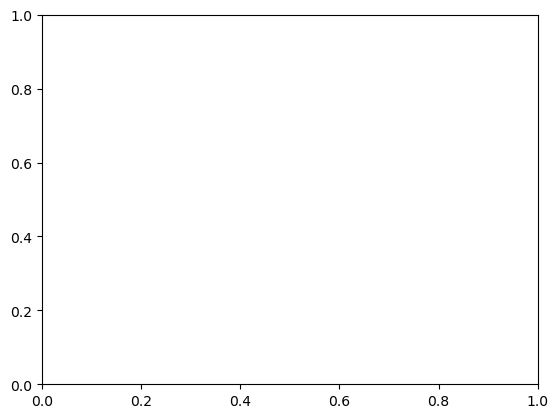

In [ ]:
#plot histogram for cls and non cls tokens on one diagram
import matplotlib.pyplot as plt
plt.hist(non_cls_diff_arr, bins=100, alpha=0.5, label='non cls')
plt.hist(cls_diff_arr, bins=100, alpha=0.5, label='cls')

In [ ]:
cls_diff_arr = cls_diff_arr[cls_diff_arr < 0.6]
non_cls_diff_arr = non_cls_diff_arr[non_cls_diff_arr < 0.6]

In [ ]:
(non_cls_diff_arr.shape[0])/(cls_diff_arr.shape[0])

48.85144217621614

ckpt1
ckpt2
ckpt3


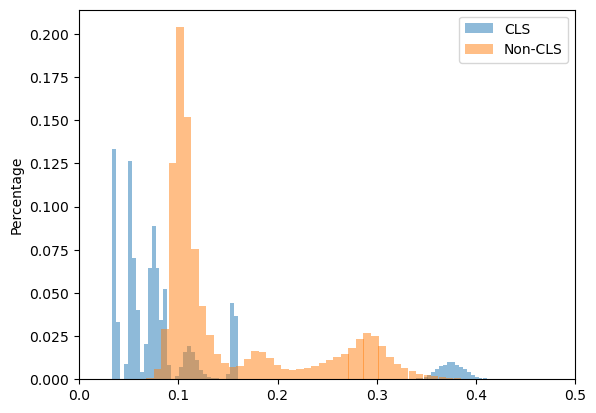

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def pool_sequence(sequence, pool_size):
    pooled_sequence = []
    for i in range(0, len(sequence), pool_size):
        pooled_sequence.append(np.mean(sequence[i:i+pool_size]))
    return np.array(pooled_sequence)

# Example sequences

# Pooling parameters
pool_size = 100

# Pooling the sequences
print("ckpt1")
pooled_sequence1 = cls_diff_arr#pool_sequence(cls_diff_arr, pool_size)
print("ckpt2")
pool_size = 500
pooled_sequence2 = non_cls_diff_arr#pool_sequence(non_cls_diff_arr, pool_size)
print("ckpt3")

# Calculate weights to display the y axis in percentage
weights1 = np.ones_like(pooled_sequence1) / len(pooled_sequence1)
weights2 = np.ones_like(pooled_sequence2) / len(pooled_sequence2)

# Plotting the histograms
plt.hist(pooled_sequence1, weights=weights1, alpha=0.5, label='CLS', bins=100)
plt.hist(pooled_sequence2, weights=weights2, alpha=0.5, label='Non-CLS', bins=100)
plt.legend()
plt.xlim(0, 0.5)
# Adding y label
plt.ylabel('Percentage')

# Display the plot
plt.show()

In [29]:
np.save('data/cls_diff_arr.npy', cls_diff_arr)
np.save('data/non_cls_diff_arr.npy', non_cls_diff_arr)

In [27]:
# Calculate weights to display the y axis in percentage
plt.figure(figsize=(20,10))
weights1 = np.ones_like(pooled_sequence1) / len(pooled_sequence1)
weights2 = np.ones_like(pooled_sequence2) / len(pooled_sequence2)

# Plotting the histograms
plt.hist(pooled_sequence1, weights=weights1, alpha=0.5, label='CLS', bins=100)
plt.hist(pooled_sequence2, weights=weights2, alpha=0.5, label='Non-CLS', bins=100)
plt.legend()

#limit x-axis to 0 and 0.6
plt.xlim(0, 0.6)

# Adding y label
plt.ylabel('Percentage')

# Display the plot
plt.show()

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../3bbc0f8d536770a62891b7cc8788c317.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.5 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 3bbc0f8d536770a62891b7cc8788c317.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../3bbc0f8d536770a62891b7cc8788c317.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.5 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 3bbc0f8d536770a62891b7cc8788c317.log.




<Figure size 600x400 with 1 Axes>

# tsne

In [12]:
no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]

model_list[0].eval()
model_list[-1].eval()

center_l2s_batches = []
with_attention_center_batches = []
no_attention_center_batches = []

attention_list = []
no_attention_list = []

with torch.no_grad():
    for i, batch in enumerate(train_loader):
        center_l2s = []
        with_attention_center_layers = []
        no_attention_center_layers = []
        X, y, img_name = batch
        X = X.to(device)

        with torch.no_grad():
            x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
            x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
            x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
            x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
            x = x + model.visual.positional_embedding.to(x.dtype)
            x = model.visual.ln_pre(x)
            x = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]

            for i in range(len(attn_blocks)):
                x = attn_blocks[i](x)
                x_no_attention = no_attention_attn_blocks[i](x)

                attention_list.append(x.cpu().numpy())
                no_attention_list.append(x_no_attention.cpu().numpy())

In [20]:
attention_arr = np.concatenate(attention_list, axis = 1)
attention_arr = attention_arr.reshape(-1, 768)
no_attention_arr = np.concatenate(no_attention_list, axis = 1)
no_attention_arr = no_attention_arr.reshape(-1, 768)

In [40]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming you have two arrays named 'array1' and 'array2'
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10
plt.rcParams["image.cmap"] = "viridis"


plt.style.use('tableau-colorblind10')
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(6, 4))
# Randomly sample data points from both arrays
sample_size = 10000
random_indices = np.random.choice(len(attention_arr), size=sample_size, replace=False)
sampled_data = np.concatenate([no_attention_arr[random_indices], attention_arr[random_indices]])

labels = np.zeros(sample_size*2)
labels[sample_size:] = 1

# Perform t-SNE on the sampled data
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(sampled_data)

# Create a scatter plot of the t-SNE results with color labeling

plt.scatter(tsne_result[labels == 1, 0], tsne_result[labels == 1, 1], color='blue', alpha=0.2, label='w/ MSA', s=5)
plt.scatter(tsne_result[labels == 0, 0], tsne_result[labels == 0, 1], color='red', alpha=0.2, label='w/o MSA (Ours)', s=5)
# plt.title('t-SNE Visualization')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
plt.legend()
plt.show()

/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../3bbc0f8d536770a62891b7cc8788c317.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.5 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 3bbc0f8d536770a62891b7cc8788c317.log.




<Figure size 600x400 with 1 Axes>

In [18]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle


def get_tsne_result(layer):
    print(layer)
    no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
    attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]

    model_list[0].eval()
    model_list[-1].eval()

    center_l2s_batches = []
    with_attention_center_batches = []
    no_attention_center_batches = []

    attention_list = []
    no_attention_list = []

    with torch.no_grad():
        for i, batch in enumerate(train_loader):
            center_l2s = []
            with_attention_center_layers = []
            no_attention_center_layers = []
            X, y, img_name = batch
            X = X.to(device)

            with torch.no_grad():
                x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
                x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
                x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
                x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
                x = x + model.visual.positional_embedding.to(x.dtype)
                x = model.visual.ln_pre(x)
                x = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]

                for i in range(len(attn_blocks)):
                    x = attn_blocks[i](x)
                    x_no_attention = no_attention_attn_blocks[i](x)
                    if i == layer:
                        attention_list.append(x.cpu().numpy())
                        no_attention_list.append(x_no_attention.cpu().numpy())
    

    attention_arr = np.concatenate(attention_list, axis = 1)
    attention_arr = attention_arr.reshape(-1, 768)
    no_attention_arr = np.concatenate(no_attention_list, axis = 1)
    no_attention_arr = no_attention_arr.reshape(-1, 768)

    sample_size = 5000
    random_indices = np.random.choice(len(attention_arr), size=sample_size, replace=False)
    sampled_data = np.concatenate([no_attention_arr[random_indices], attention_arr[random_indices]])

    labels = np.zeros(sample_size*2)
    labels[sample_size:] = 1

    # Perform t-SNE on the sampled data
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(sampled_data)

    with open(f'tsne_result/tsne_result_l{layer+1}.pkl', 'wb') as f:
        pickle.dump(tsne_result, f)

In [19]:
for layer in range(12):
    get_tsne_result(layer)

0


/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


1


/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


2


/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


3


/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


4


/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


5


/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


6


/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


7


/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


8


/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


9


/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


10


/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


11


/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [67]:
attention_arr = np.concatenate(attention_list, axis = 1)
attention_arr = attention_arr.reshape(-1, 768)
no_attention_arr = np.concatenate(no_attention_list, axis = 1)
no_attention_arr = no_attention_arr.reshape(-1, 768)

/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hc3295/anaconda3/envs/vanilla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


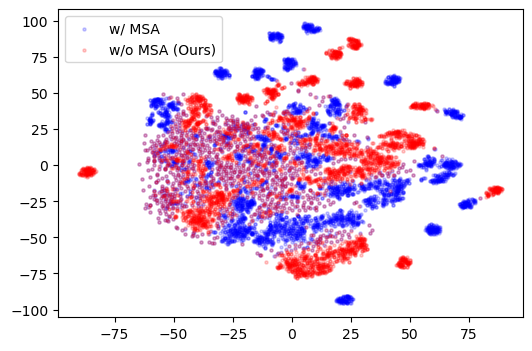

In [68]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming you have two arrays named 'array1' and 'array2'
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10
plt.rcParams["image.cmap"] = "viridis"


plt.style.use('tableau-colorblind10')
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(6, 4))
# Randomly sample data points from both arrays
sample_size = 5000
random_indices = np.random.choice(len(attention_arr), size=sample_size, replace=False)
sampled_data = np.concatenate([no_attention_arr[random_indices], attention_arr[random_indices]])

labels = np.zeros(sample_size*2)
labels[sample_size:] = 1

# Perform t-SNE on the sampled data
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(sampled_data)

# Create a scatter plot of the t-SNE results with color labeling

plt.scatter(tsne_result[labels == 1, 0], tsne_result[labels == 1, 1], color='blue', alpha=0.2, label='w/ MSA', s=5)
plt.scatter(tsne_result[labels == 0, 0], tsne_result[labels == 0, 1], color='red', alpha=0.2, label='w/o MSA (Ours)', s=5)
# plt.title('t-SNE Visualization')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [69]:
import pickle

with open('data/tsne_result_l5.pkl', 'wb') as f:
    pickle.dump(tsne_result, f)